In [1]:
import os
print(os.path.abspath("./"))
print(os.path.abspath("../"))

import sys
sys.path.append("../")

c:\Users\Hasan\Work\akrule\notebooks
c:\Users\Hasan\Work\akrule


In [2]:
from akrule.time_series import AKRuleBasedTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import warnings
warnings.simplefilter("ignore")

# Data Prepration

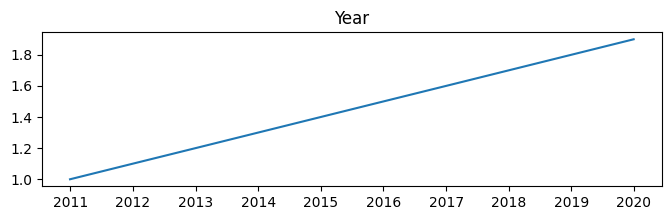

In [3]:
N = 10
data_year = np.ones(N)
trend = np.arange(0,N) / N
data_year += trend
df_year = pd.DataFrame()
df_year["y"] = data_year
df_year.index = pd.date_range(start='1/1/2010', end='1/1/2020', freq="1Y")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_year.index, df_year.y)
ax.set_title("Year");

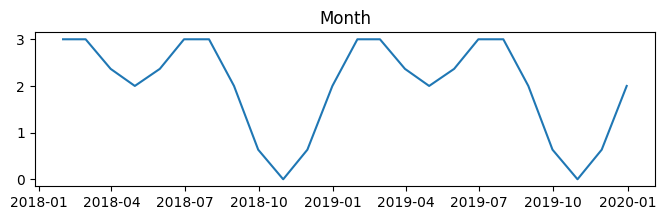

In [4]:
N = 24
x = np.arange(0,N)
y =  np.sin(4*np.pi*x/N)+np.cos(8*np.pi*x/N)+2
df_month = pd.DataFrame()
df_month["y"] = y
df_month.index = pd.date_range(start='1/1/2018', end='1/1/2020', freq="1M")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_month.index, df_month.y)
ax.set_title("Month");

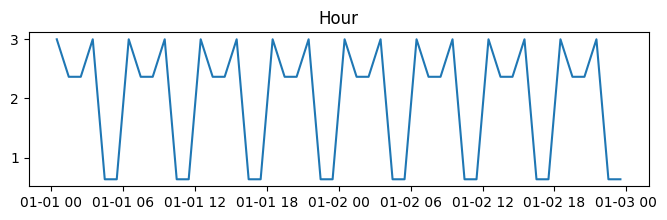

In [5]:
N = 48
x = np.arange(0,N)
y =  np.sin(16*np.pi*x/N)+np.cos(32*np.pi*x/N)+2
df_hour = pd.DataFrame()
df_hour["y"] = y
df_hour.index = pd.date_range(start='1/1/2020 00:30:00', end='1/3/2020', freq="1H")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_hour.index, df_hour.y)
ax.set_title("Hour");

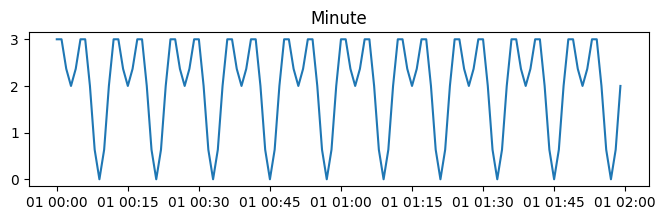

In [6]:
N = 120
x = np.arange(0,N)
y =  np.sin(20*np.pi*x/N)+np.cos(40*np.pi*x/N)+2
df_minute = pd.DataFrame()
df_minute["y"] = y
df_minute.index = pd.date_range(start='1/1/2020 00:00:01', end='1/1/2020 02:00:00', freq="1T")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_minute.index, df_minute.y)
ax.set_title("Minute");

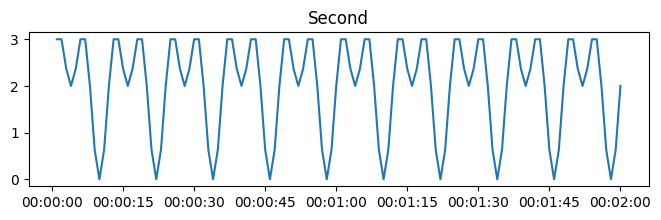

In [7]:
N = 120
x = np.arange(0,N)
y =  np.sin(20*np.pi*x/N)+np.cos(40*np.pi*x/N)+2
df_second = pd.DataFrame()
df_second["y"] = y
df_second.index = pd.date_range(start='1/1/2020 00:00:01', end='1/1/2020 00:02:00', freq="1S")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_second.index, df_second.y)
ax.set_title("Second");

# Test

In [8]:
import warnings
from sklearn.metrics import r2_score


def QAPE_Percentage_Bootstrap_Score(y_true, y_pred, num_samples=1000, ci=0.95):
    """
    """
    error = np.abs(np.subtract(y_true, y_pred)) / np.maximum(np.abs(y_true), np.finfo(np.float64).eps)
    
    idx = np.random.randint(0, error.shape[0], size=(num_samples, error.shape[0]))
    resamples_error = error[idx]
    
    quantile_error = np.quantile(resamples_error, ci, axis=1)
    return quantile_error.mean()

def QAPE_Amount_Bootstrap_Score(y_true, y_pred, num_samples=1000, ci=0.95):
    """
    """
    error = np.abs(np.subtract(y_true, y_pred))
    
    idx = np.random.randint(0, error.shape[0], size=(num_samples, error.shape[0]))
    resamples_error = error[idx]
    
    quantile_error = np.quantile(resamples_error, ci, axis=1)
    return quantile_error.mean()

def QAPE_Mix_Score(group, num_samples=1000, ci=0.95):
    """
    """
    y_true = group.y.values
    y_pred = group.y_pred.values
    error_per = np.abs(np.subtract(y_true, y_pred)) / np.maximum(np.abs(y_true), np.finfo(np.float64).eps)
    error_amo = np.abs(np.subtract(y_true, y_pred))
    
    idx = np.random.randint(0, error_per.shape[0], size=(num_samples, error_per.shape[0]))
    resamples_error_per = error_per[idx]
    resamples_error_amo = error_amo[idx]
    
    quantile_error_per = np.quantile(resamples_error_per, ci, axis=1)
    quantile_error_amo = np.quantile(resamples_error_amo, ci, axis=1)
    
    group["ScoreQAPE_PER"] = quantile_error_per.mean()
    group["ScoreQAPE_AMO"] = quantile_error_amo.mean()
    group["ScoreR2"] = r2_score(y_true[np.isfinite(y_true)], y_pred[np.isfinite(y_pred)])
    return group
    
        
class AKRuleBasedTS():
    """
    """
    
    def __init__(self, freqs: list=[], tag_features: list=[], average_num: int=3, trend_level: int=0, holidays: bool=False, fillna: bool=True, inplace: bool=False, 
                 metric_num_samples=1000, metric_ci=0.95):
        self.freqs = freqs
        self.tag_features = tag_features
        self.average_num = average_num
        self.trend_level = trend_level
        self.trend_x = None
        self.trend_dict = {}
        self.holidays = holidays
        self.fillna = fillna
        self.inplace = inplace
        self.metric_num_samples = metric_num_samples
        self.metric_ci = metric_ci
        self.df_rule = None
        self.scores = None
        
        if not isinstance(self.freqs, list): raise TypeError("freqs must be list format!")
        if not isinstance(self.tag_features, list): raise TypeError("tag_features must be list format!")
        if not isinstance(self.average_num, int): raise TypeError("average_num must be int format!")
        if not isinstance(self.trend_level, int): raise TypeError("trend_level must be int format!")
        if not isinstance(self.holidays, bool): raise TypeError("holidays must be bool format!")
        if not isinstance(self.fillna, bool): raise TypeError("fillna must be bool format!")
        if not isinstance(self.inplace, bool): raise TypeError("inplace must be bool format!")
        if not isinstance(self.metric_num_samples, int): raise TypeError("metric_num_samples must be int format!")
        if not isinstance(self.metric_ci, float): raise TypeError("metric_ci must be float format!")
        
        for index, freq in enumerate(self.freqs):
            self.freqs[index] = freq.upper()
        
        self.freqs_order = ["YEARLY", "MONTHLY", "WEEKLY", "DAYOFYEAR", "DAYOFMONTH", "DAYOFWEEK", "HOURLY", "MINUTELY"]
        self.freq_order = None
        for freq_order in self.freqs_order:
            if freq_order.upper() in self.freqs:
                self.freq_order = freq_order
        if self.freq_order is None and fillna:
            self.fillna = False
            warnings.warn(f"Warning... There should be frequency like {self.freqs_order}!")
    
    def _check_data(self, X: pd.DataFrame, method: str="fit"):
        if not "time" in X.columns:
            raise KeyError("There is no time feature in DataFrame!")
        if not isinstance(X.time.values[0], np.datetime64):
            raise TypeError("time is not np.datetime64 format!")
        if method=="fit":
            if not "y" in X.columns:
                raise KeyError("There is no y feature in DataFrame!")
            if not isinstance(X.y.values[0], (int, float)):
                raise TypeError("y is not numeric format!")
        for tag in self.tag_features:
            if not tag in X.columns:
                raise KeyError(f"There is no {tag} feature in DataFrame!")
        if len(self.tag_features) == 0:
            self.tag_features = ["TEMP"]
            X["TEMP"] = True
        return X
    
    def _fillna(self, X: pd.DataFrame):
        def __fillna_group(group):
            group.infer_objects(copy=False).interpolate(method='linear', inplace=True)
            group.ffill(inplace=True)
            group.bfill(inplace=True)
            return group
        
        if self.freq_order == "YEARLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1Y")
        elif self.freq_order == "MONTHLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1M")
        elif self.freq_order == "WEEKLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1W")
        elif self.freq_order == "DAYOFYEAR":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "DAYOFMONTH":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "DAYOFWEEK":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "HOURLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1H")
        elif self.freq_order == "MINUTELY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1T")
        
        df_time = pd.DataFrame(time_index, columns=["time"])
        X_tags = X[self.tag_features].drop_duplicates()
        df_time = df_time.merge(X_tags, how="cross")

        X = X.merge(df_time, on=["time"]+self.tag_features, how="right")        
        X["isna"] = X.y.isna()
        X = X.groupby(self.tag_features, as_index=False).apply(lambda group: __fillna_group(group))
        X.reset_index(drop=True, inplace=True)
        return X
    
    def _set_trend(self, X: pd.DataFrame):
        trend_cols = [f"res_polyfit{i}" for i in range(self.trend_level+1)]
        tag = self.tag_features[0]
        value = X[tag].unique()[0]
        self.trend_x = np.arange(X[X[tag]==value].shape[0])
        res = X.groupby(self.tag_features).apply(lambda x: pd.Series(np.polyfit(self.trend_x, x.y, self.trend_level), 
                                                                                    index=trend_cols))
            
        time_values = X["time"].unique()
        if len(time_values) != self.trend_x.shape[0]: raise ValueError("Unique time shape does not match y values shape!")
        trend_preds = []
        for index, row in res.iterrows():
            self.trend_dict[index] = np.poly1d(row.values)
            trend_pred = pd.DataFrame()
            trend_pred["time"] = time_values
            trend_pred["y_trend"] = self.trend_dict[index](self.trend_x)
            trend_pred[self.tag_features] = index
            trend_preds.append(trend_pred)
        trend_preds = pd.concat(trend_preds) if len(trend_preds)>1 else trend_preds[0]
        
        X = X.merge(trend_preds, on=["time"]+self.tag_features, how="left")
        X["y_notrend"] = X["y"] - X["y_trend"]
        return X
    
    def _set_freqs(self, X: pd.DataFrame):
        for freq in self.freqs:
            if freq.upper() == "YEARLY":
                X["YEARLY"] = X.time.dt.year.astype(np.int8)
            elif freq.upper() == "DAYOFYEAR":
                X["DAYOFYEAR"] = X.time.dt.dayofyear.astype(np.int8)
            elif freq.upper() == "MONTHLY":
                X["MONTHLY"] = X.time.dt.month.astype(np.int8)
            elif freq.upper() == "DAYOFMONTH":
                X["DAYOFMONTH"] = X.time.dt.day.astype(np.int8)
            elif freq.upper() == "WEEKLY":
                #X["WEEKLY"] = X.time.dt.isocalendar().week.astype(np.int8)
                #X["WEEKLY"] = (X["WEEKLY"] % 4).astype(np.int8)
                X["WEEKLY"] = (X.time.dt.day // 7 + 1).astype(np.int8)
                X["WEEKLY"].clip(upper=4, inplace=True)
            elif freq.upper() == "DAYOFWEEK":
                X["DAYOFWEEK"] = X.time.dt.dayofweek.astype(np.int8)
            elif freq.upper() == "HOURLY":
                X["HOURLY"] = X.time.dt.hour.astype(np.int8)
            elif freq.upper() == "MINUTELY":
                X["MINUTELY"] = X.time.dt.minute.astype(np.int8)
    
    def _get_median_preds(self, X: pd.DataFrame):  
        def add_index_freqs(group):
            group["pred_index"] = (group[self.freqs[0]] != group[self.freqs[0]].shift()).cumsum()
            return group
        def add_index(group):
            group["pred_index"] = np.arange(group.shape[0])
            return group
        
        if len(self.freqs)>1:
            X = X.groupby(self.tag_features, as_index=False).apply(add_index_freqs)
        else:
            X = X.groupby(self.tag_features, as_index=False).apply(add_index)
        
        X_group = X.groupby(self.freqs[1:]+self.tag_features).rolling(self.average_num).agg({
            "y_notrend":"median",
            "pred_index":"max"
        })
        
        X_group.reset_index(inplace=True)
        X_group["pred_index"] += 1
        X_group.rename(columns={"y_notrend":"y_notrend_pred"}, inplace=True)
        
        self.df_rule = X_group.loc[X_group["pred_index"].isin([X_group["pred_index"].max(), X_group["pred_index"].max()-1]), 
                                   self.freqs[1:]+self.tag_features+["y_notrend_pred"]]
        self.df_rule = self.df_rule.groupby(self.freqs[1:]+self.tag_features).agg({
            "y_notrend_pred":"last"
        })
        self.df_rule.reset_index(inplace=True)
        self.df_rule[self.freqs[1:]] = self.df_rule[self.freqs[1:]].astype(np.int8)
        self.df_rule[self.tag_features] = self.df_rule[self.tag_features].astype(str)
        
        X = X.merge(X_group[self.freqs[1:]+self.tag_features+["y_notrend_pred", "pred_index"]], on=self.freqs[1:]+self.tag_features+["pred_index"], how="left")
        return X
    
    def _set_scores(self, X: pd.DataFrame):
        scores = X.groupby(self.tag_features, as_index=False).apply(lambda group: pd.Series(
            {
                'ScoreQAPE_PER': QAPE_Percentage_Bootstrap_Score(group['y_notrend'].values, group['y_notrend_pred'].values, num_samples=self.metric_num_samples, ci=self.metric_ci),
                'ScoreQAPE_AMO': QAPE_Amount_Bootstrap_Score(group['y_notrend'].values, group['y_notrend_pred'].values, num_samples=self.metric_num_samples, ci=self.metric_ci),
                'ScoreR2': r2_score(group['y_notrend'].values, group['y_notrend_pred'].values)
            }
        ))
        self.scores = scores
    
    def _get_boundary(self, X: pd.DataFrame):
        X = X.merge(self.scores, on=self.tag_features, how="left")
        X["offset"] = (X["y_notrend_pred"] * X["ScoreQAPE_PER"]).abs()
        X["offset"] = np.where(X["offset"]>X["ScoreQAPE_AMO"], X["offset"], X["ScoreQAPE_AMO"])
        X["y_notrend_lower"] = X["y_notrend_pred"] - X["offset"]
        X["y_notrend_upper"] = X["y_notrend_pred"] + X["offset"]
        X["y_pred"] = X["y_notrend_pred"] + X["y_trend"]
        X["y_lower"] = X["y_notrend_lower"] + X["y_trend"]
        X["y_upper"] = X["y_notrend_upper"] + X["y_trend"]
        return X
    
    def fit_predict(self, X_ori: pd.DataFrame):
        X = X_ori if self.inplace else X_ori.copy()
        X = self._check_data(X, method="fit")        
        X = self._fillna(X) if self.fillna else X.assign(isna=X.y.isna())
        X = self._set_trend(X) if self.trend_level>0 else X.assign(y_notrend=X.y)
        self._set_freqs(X)
        X = self._get_median_preds(X)
        #display(X)
        X_clear = X[self.tag_features+["y_notrend", "y_notrend_pred"]].dropna()
        #display(X_clear)
        self._set_scores(X_clear)
        X_scores = self._get_boundary(X)
        #display(X_scores)
        
        """
        # Rolling
        best_score, best_roll = 999, -1
        for index, minute_round in enumerate(self.minute_round):
            X_tr["y_pred_roll"] = X_tr.y_pred.rolling(minute_round,center=True).median()
            y_true = X_tr.y
            y_pred = X_tr.y_pred_roll
            roll_score = QAPE_75(y_true,y_pred)
        """        
        
        """
        # Holiday Prediction
        """
        
        """
        # Prediction Calibration
        """
        
        return_features = ["time", "y", "y_pred", "y_lower", "y_upper"] + self.tag_features
        return X_scores[return_features]
    
    def fit(self, X_ori: pd.DataFrame):
        self.fit_predict(X_ori)
    
    def predict(self, X_ori: pd.DataFrame, period: bool=False):
        if not period:
            X = X_ori if self.inplace else X_ori.copy()
            X = self._check_data(X, method="predict")  
            self._set_freqs(X) 
            X_pred = X.merge(self.df_rule, on=self.freqs[1:]+self.tag_features,how="left")
            
            tag = self.tag_features[0]
            value = X_pred[tag].unique()[0]
            trend_x = np.arange(X_pred[X_pred[tag]==value].shape[0])
            trend_x += self.trend_x.max() + 1
            
            def add_trend(group, group_name):
                linear_model = self.trend_dict[group_name[0]] if len(self.tag_features) == 1 else self.trend_dict[group_name]
                group["y_trend"] = linear_model(trend_x)
                return group
            
            X_pred = X_pred.groupby(self.tag_features, as_index=False).apply(lambda group: add_trend(group, group.name))
            X_pred = self._get_boundary(X_pred)
            
            return_features = ["time", "y_pred", "y_lower", "y_upper"] + self.tag_features
            return X_pred[return_features]
        else:
            raise ValueError("period parameter is not working yet!")
    

## Daily-Hourly-Minutely

In [9]:
from akrule.time_series import get_daily_hourly_minutely_data

df_minutely = get_daily_hourly_minutely_data(N=5, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=1))
X_train_minutely = df_minutely[df_minutely["time"]<split_time].copy()
X_test_minutely = df_minutely[df_minutely["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["dayofweek", "hourly", "minutely"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_minutely)
X_pred = model.predict(X_test_minutely.drop(["y"], axis=1))

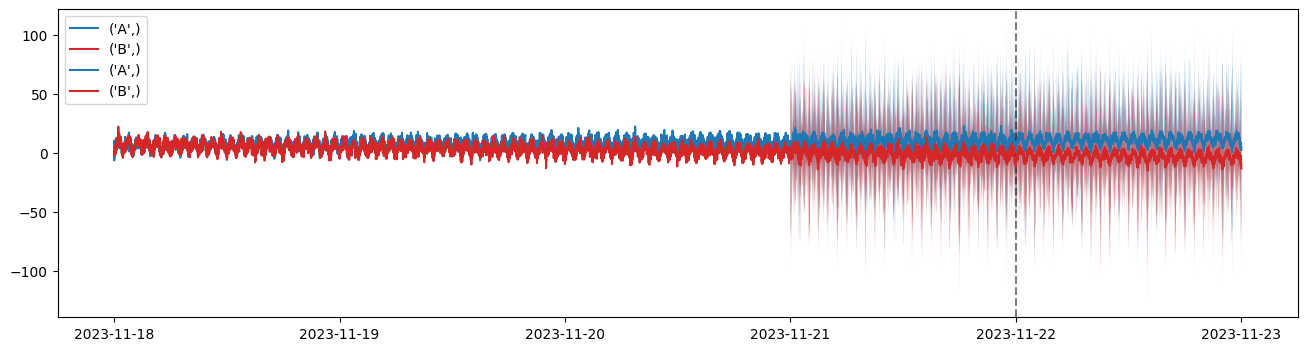

In [10]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Daily-Hourly

In [11]:
from akrule.time_series import get_daily_hourly_data

df_hourly = get_daily_hourly_data(N=30, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7))
X_train_hourly = df_hourly[df_hourly["time"]<split_time].copy()
X_test_hourly = df_hourly[df_hourly["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["dayofweek", "hourly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_hourly)
X_pred = model.predict(X_test_hourly.drop(["y"], axis=1))

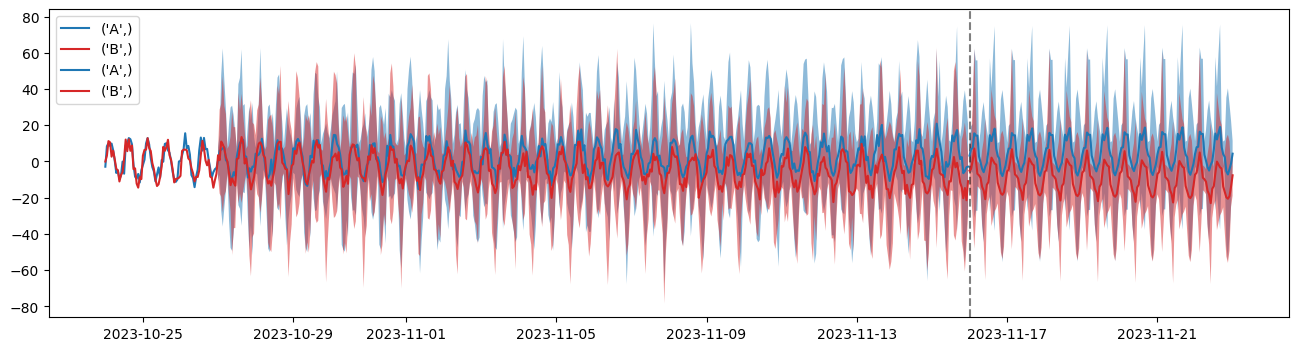

In [12]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Daily

In [13]:
from akrule.time_series import get_daily_data

df_daily = get_daily_data(N=30, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7))
X_train_daily = df_daily[df_daily["time"]<split_time].copy()
X_test_daily = df_daily[df_daily["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["dayofweek"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_daily)
X_pred = model.predict(X_test_daily.drop(["y"], axis=1))

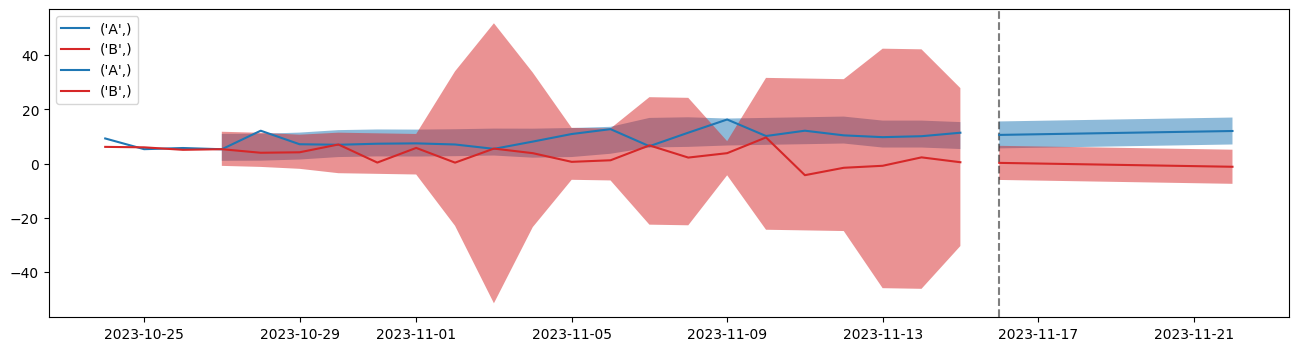

In [14]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Weekly-Daily-Hourly

In [15]:
from akrule.time_series import get_weekly_daily_hourly_data

df_hourly = get_weekly_daily_hourly_data(N=30, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7))
X_train_hourly = df_hourly[df_hourly["time"]<split_time].copy()
X_test_hourly = df_hourly[df_hourly["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["weekly", "dayofweek", "hourly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_hourly)
X_pred = model.predict(X_test_hourly.drop(["y"], axis=1))

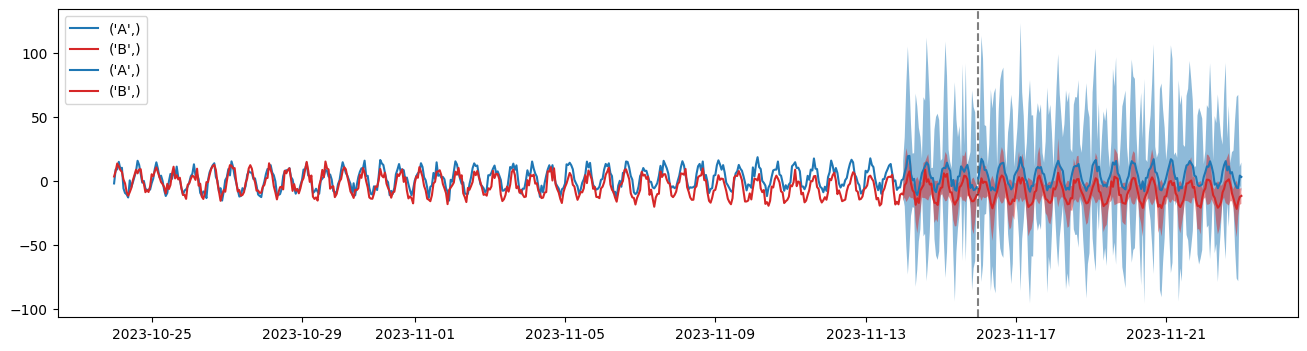

In [16]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Weekly-Daily

In [17]:
from akrule.time_series import get_weekly_daily_data

df_daily = get_weekly_daily_data(N=10, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7*3))
X_train_daily = df_daily[df_daily["time"]<split_time].copy()
X_test_daily = df_daily[df_daily["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["weekly", "dayofweek"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_daily)
X_pred = model.predict(X_test_daily.drop(["y"], axis=1))

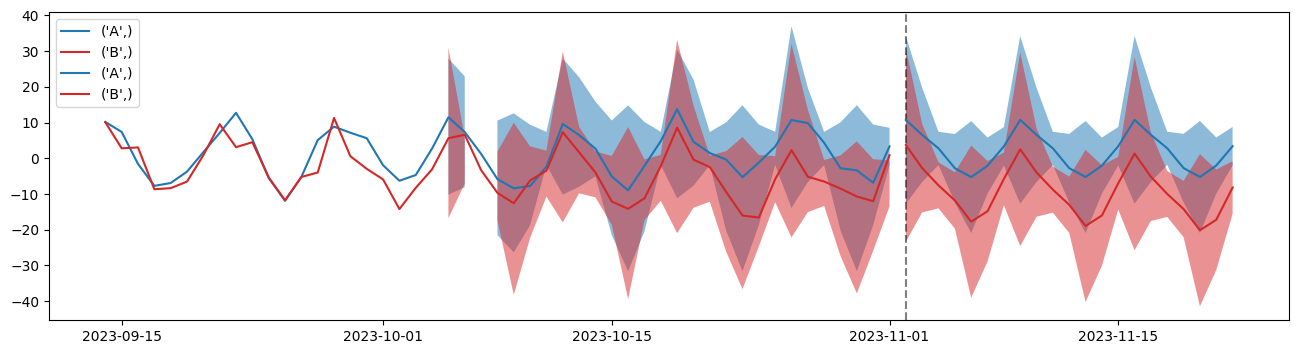

In [18]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Weekly

In [19]:
from akrule.time_series import get_weekly_data

df_weekly = get_weekly_data(N=20, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7*3))
X_train_weekly = df_weekly[df_weekly["time"]<split_time].copy()
X_test_weekly = df_weekly[df_weekly["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["weekly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_weekly)
X_pred = model.predict(X_test_weekly.drop(["y"], axis=1))

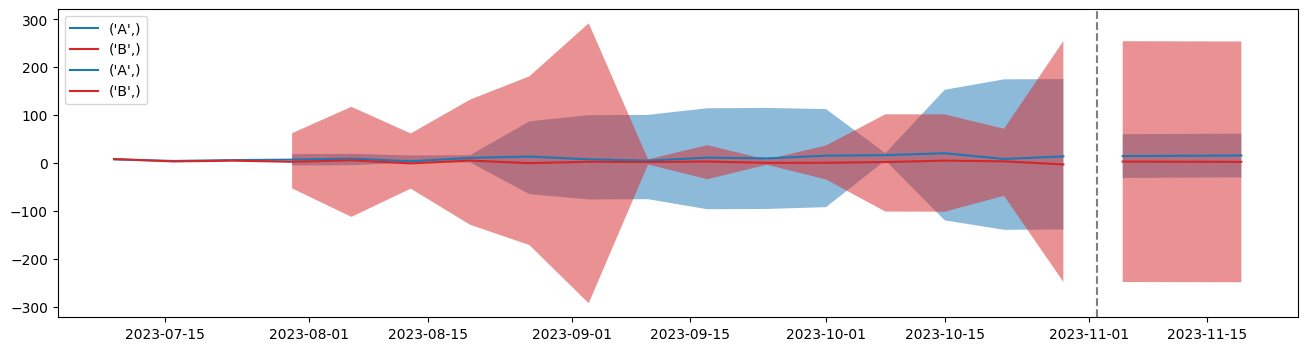

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Monthly-Weekly-Daily

In [21]:
from akrule.time_series import get_monthly_weekly_daily_data

df_daily = get_monthly_weekly_daily_data(N=150, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7*2))
X_train_daily = df_daily[df_daily["time"]<split_time].copy()
X_test_daily = df_daily[df_daily["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["monthly", "weekly", "dayofweek"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_daily)
X_pred = model.predict(X_test_daily.drop(["y"], axis=1))

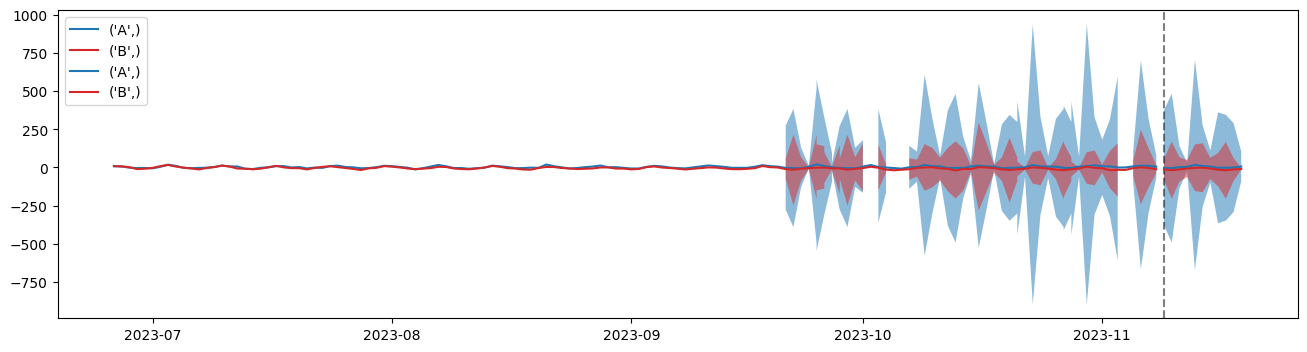

In [22]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Monthly-Weekly

In [23]:
from akrule.time_series import get_monthly_weekly_data

df_weekly = get_monthly_weekly_data(N=56, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=7*2))
X_train_weekly = df_weekly[df_weekly["time"]<split_time].copy()
X_test_weekly = df_weekly[df_weekly["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["monthly", "weekly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_weekly)
X_pred = model.predict(X_test_weekly.drop(["y"], axis=1))

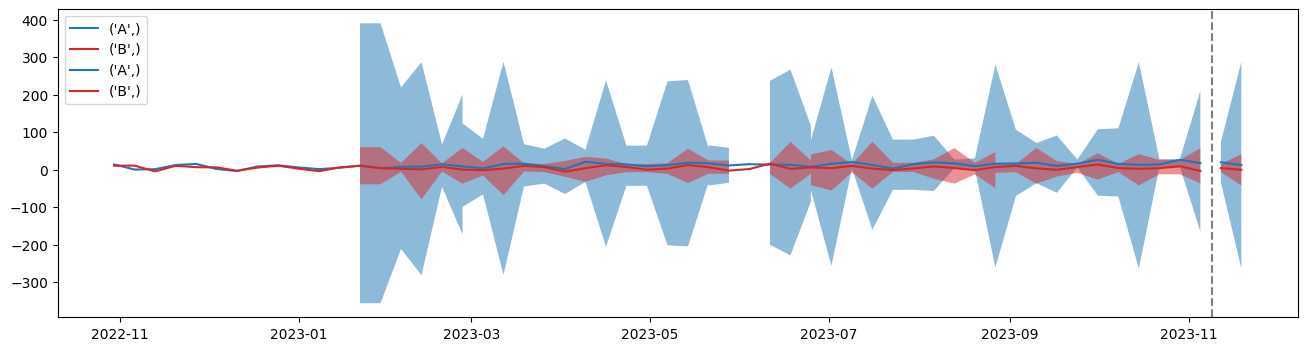

In [24]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Monthly

In [25]:
from akrule.time_series import get_monthly_data

df_monthly = get_monthly_data(N=24, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=30.47*4))
X_train_monthly = df_monthly[df_monthly["time"]<split_time].copy()
X_test_monthly = df_monthly[df_monthly["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["monthly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_monthly)
X_pred = model.predict(X_test_monthly.drop(["y"], axis=1))

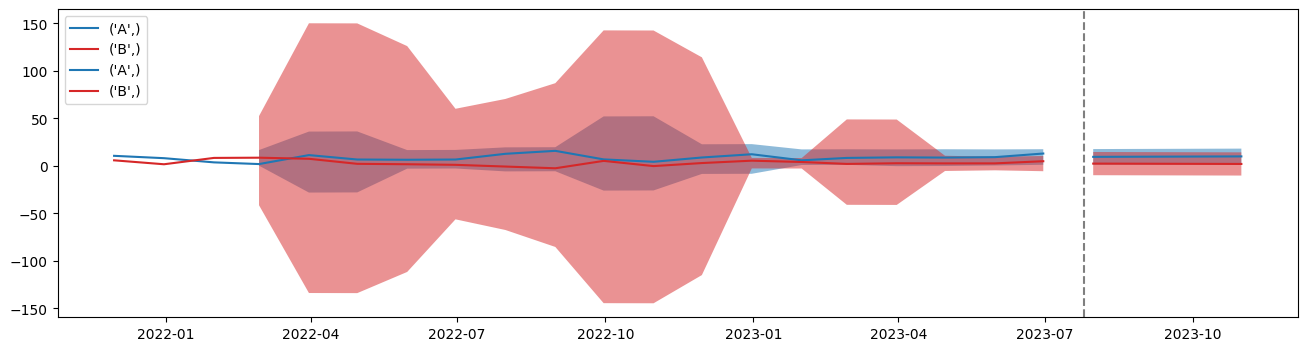

In [26]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Yearly-Monthly-Daily

In [27]:
from akrule.time_series import get_yearly_monthly_daily_data

df_daily = get_yearly_monthly_daily_data(N=48, max_value=10, noise_std=3, anomaly_percentage=0)
split_time = str(datetime.now().date() - timedelta(days=365.64*1))
X_train_daily = df_daily[df_daily["time"]<split_time].copy()
X_test_daily = df_daily[df_daily["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["yearly", "monthly", "dayofmonth"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_daily)
X_pred = model.predict(X_test_daily.drop(["y"], axis=1))

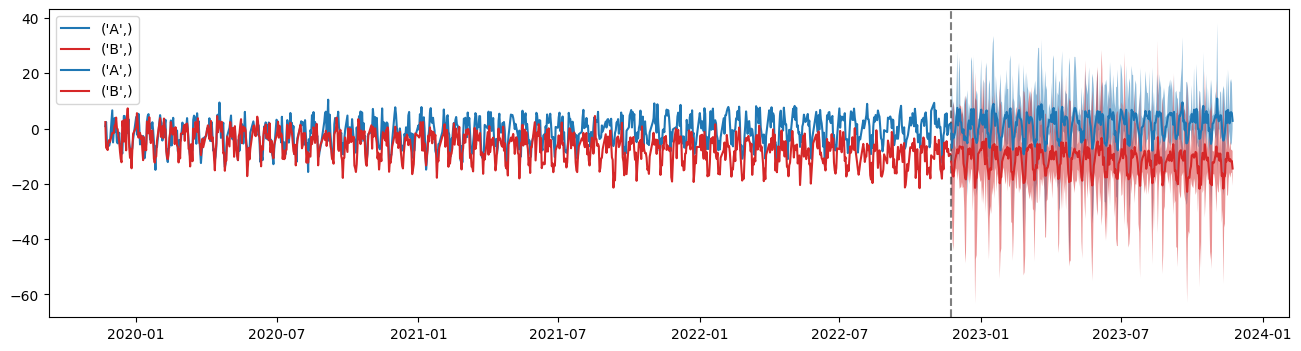

In [28]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Yearly-Monthly

In [29]:
from akrule.time_series import get_yearly_monthly_data

df_month = get_yearly_monthly_data(N=96, max_value=100, noise_std=5.5, anomaly_percentage=5)
split_time = str(datetime.now().date() - timedelta(days=365.64*1))
X_train_month = df_month[df_month["time"]<split_time].copy()
X_test_month = df_month[df_month["time"]>=split_time].copy()

tag_features = ["Country"]
model = AKRuleBasedTS(freqs=["yearly", "monthly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_month)
X_pred = model.predict(X_test_month.drop(["y"], axis=1))

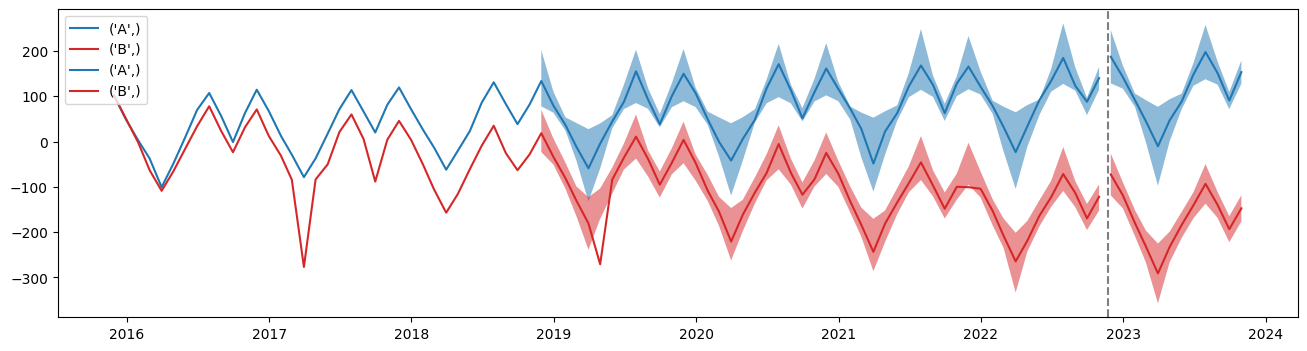

In [30]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

## Yearly

In [31]:
from akrule.time_series import get_yearly_data

df_year = get_yearly_data(N=100, max_value=100, noise_std=5.5, anomaly_percentage=5)
split_time = str(datetime.now().date() - timedelta(days=365.64*10))
X_train_year = df_year[df_year["time"]<split_time].copy()
X_test_year = df_year[df_year["time"]>=split_time].copy()

tag_features = ["Country", "City"]
model = AKRuleBasedTS(freqs=["yearly"], tag_features=tag_features, average_num=3, trend_level=1, fillna=True, metric_ci=0.95, inplace=False)
X_val = model.fit_predict(X_train_year)
X_pred = model.predict(X_test_year.drop(["y"], axis=1))

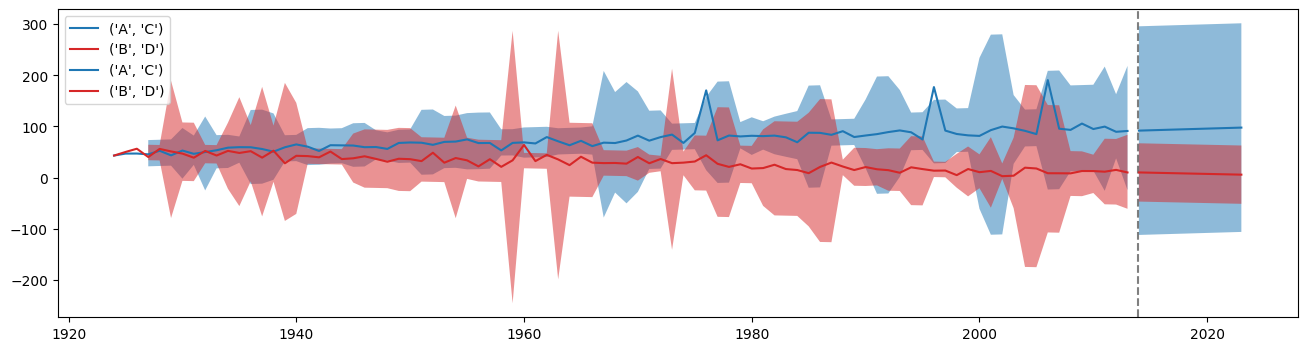

In [32]:
fig, ax = plt.subplots(figsize=(16,4))
colors = ["tab:blue", "tab:red"]
for index, (group_name, group) in enumerate(X_val.groupby(tag_features)):
    ax.plot(group.time, group.y, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.axvline(x=datetime.strptime(split_time, "%Y-%m-%d"), ls='--', color="black", alpha=0.5)
for index, (group_name, group) in enumerate(X_pred.groupby(tag_features)):
    ax.plot(group.time, group.y_pred, color=colors[index], label=group_name)
    ax.fill_between(group.time, group.y_upper, group.y_lower, facecolor=colors[index], alpha=0.5) 
ax.legend(loc='upper left');

# Break Point